# An Introduction to Autoencoders

*This is one writeup in what I'm hoping to make a series of posts on representation learning and unsupervised methods in general. I've noticed that there are far fewer resources out there detailing these topics than there are for common supervised learning topics, and next-to-none that show them off in practice (i.e. with code) along with the underlying math. I'd like these posts to be accessible to a wider audience while still providing mathematical intuition.*

## Part 1: Motivation and Introduction
*What is an autoencoder and why should I care?*

The core concept underlying all autoencoders is deceptively simple. Let's break it down from the name instead of memorizing it as just another term. The word 'autoencoder' is made up of 'auto,' meaning self, and 'encoder,' meaning something that transforms information in one form (or code) to another. An autoencoder is a neural network that takes in data, transforms it, and tries to output the same data that it was given. 

Cool. We now know what an autoencoder is. Article over, right? Well, not quite.

Our definition as it currently stands makes sense, but seems rather... useless. Why go through the trouble of training a neural network to get an imperfect approximation of the identity function when we could just return our input data? The answer is that we don't really care about the output of our network itself; in fact, when using autoencoders, we never even expect it to perfectly output the data we gave it as input. What's of importance to us is the _transformation_ step. All autoencoders 
possess some transformed intermediate state of the data between the input and output, called the **code**. The part of the autoencoder that outputs the code is unsurprisingly referred to as the **encoder**, while the remainder (which tries to reconstruct the input from the code) is perhaps even more unsurprisingly dubbed the **decoder**. 

![title](diagrams/undercomplete_ae.png)
**An illustration of an autoencoder.** Our input data $\boldsymbol x$ is fed into the encoder function $f$ to create the code; the code is in turn fed into the decoder $\boldsymbol g$ to obtain the output, which we will compare to our input. (In particular, this is visually closest to an _undercomplete_ autoencoder, described in the next section.

As things currently stand, however, this 'code' doesn't seem particularly useful either. One can easily imagine a neural network with enough capacity being perfectly happy to create some arbitrary approximately invertible function as the encoder and its inverse as the decoder, changing both in tandem to get the identity function as their composite. But the key to (useful) autoencoders is that we aren't going to let our network learn the identity function alone; we're instead going to bully it into learning a code with properties we'd like to have in a(n approximately invertible) transformation of our data at the expense of being able to perfectly reconstruct the input.

Thus, autoencoders are an extremely powerful framework for _representation learning_. Once we come up with properties we'd like to have in a representation of our data, we can try and constrain our network to learn a code with those properties. 

## Part 2:  Undercomplete Autoencoders

Now that we have this framework in mind, let's think of properties we might like a representation to have. Oftentimes, the data we are working with is high-dimensional in nature. In order to avoid the curse of dimensionality or to extract semantically meaningful features, we might want some low-dimensional representation of our high-dimensional data -- hence the existence of a whole host of dimensionality reduction techniques in the literature, most well-known being by way of principal components analysis (PCA). (This was actually the original motivation behind the autoencoder, and can be considered the most 'vanilla' flavor of them.) 

Thus, we bottleneck the number of dimensions in our network at the code to be lower than the number of dimensions in the input data. We then structure our decoder as a function from the lower number of dimensions to the original number to bring it back up.

Let's see what that looks like in code instead of words! For our first autoencoder, we'll use simple linear transformations for encoding and decoding so we can reason about what's going on intuitively, but keep in mind the main power behind autoencoders comes from their use of neural networks (i.e. incredibly versatile function approximators) for both steps.

In [1]:
# imports
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(42); # set seed for consistent results

We first must define how many dimensions we want the code to be. This is highly dependent on the number of dimensions in the input -- there is no magic number you can always pick that will give you the results you want! (It also depends on what you plan on using the code for; but these are considerations for downstream tasks.) 

In [2]:
input_dimensions = 784
code_dimensions = 32

We're going to define classes for the encoder and decoder networks. This might seem redundant with our small network now, but is good practice for making encoders and decoders with more complicated architectures than a single linear layer.

In [3]:
class Encoder(nn.Module):
    """
    Encoder class for linear autoencoder. Takes in data of dimension `input_dimensions`, 
    conducts a linear transformation, and outputs the resulting code of dimension `code_dimensions`.
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, code_dimensions, bias=False)
    def forward(self, x: torch.Tensor):
        return self.fc1(x)

In [4]:
class Decoder(nn.Module):
    """
    Decoder class for linear autoencoder. Takes in data of dimension `code_dimensions`, 
    conducts a linear transformation, and outputs the resulting output of dimension `input_dimensions`.
    """
    def __init__(self, code_dimensions: int, input_dimensions: int):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(code_dimensions, input_dimensions, bias=False)
    def forward(self, x: torch.Tensor):
        return self.fc1(x)

Our full autoencoder is then the encoder followed by the decoder.

In [5]:
class LinearAutoencoder(nn.Module):
    """
    Class for linear autoencoder. Composite of Encoder and Decoder classes above.
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(LinearAutoencoder, self).__init__()
        self.encode = Encoder(input_dimensions, code_dimensions)
        self.decode = Decoder(code_dimensions, input_dimensions)
    def forward(self, x: torch.Tensor):
        x = self.encode(x) # from input_dimensions->code_dimensions...
        x = self.decode(x) # and back from code_dimensions->input_dimensions
        return x

Now we have some general setup to do before we can get training, but this is somewhat usecase-specific and not that important to understanding autoencoders conceptually.

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# some hyperparameters
batch_sz = 32
test_batch_sz = 100

learning_rate = 10**(-1.5)
momentum = 0.5

n_epochs = 20

In [8]:
# set dataloader kwargs
kwargs = {'num_workers': 1, 'pin_memory':True} if torch.cuda.is_available() else {}

In [9]:
# preprocessing
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# create dataloaders to serve up MNIST images as example data -- see MNIST example in the official documentation 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform= img_transform),
    batch_size=batch_sz,
    shuffle=True,
    **kwargs
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=img_transform),
    batch_size=test_batch_sz,
    shuffle=True,
    **kwargs
)

We'll set up our model and use stochastic gradient descent with momentum as our optimizer (simplicity is always best when complexity isn't necessary!).

In [12]:
model = LinearAutoencoder(input_dimensions, code_dimensions).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [14]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, 
          train_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Executes one epoch of training given a model, optimizer, device, dataloader, and epoch number.
    """
    model.train()
    for batch_idx, (inp, label) in enumerate(train_loader):
        inp = inp.view(-1, input_dimensions)
        inp = inp.to(device) 
        output = model(inp) # here we put the input image through the autoencoder
        loss = F.mse_loss(output, inp) # then compare output to input via mean-square-error
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Died')
            break
        
        loss.backward() # compute gradients
        optimizer.step() # conduct step of gradient descent
        optimizer.zero_grad() # zero out gradients to avoid messing with future iterations
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inp), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
def test(model: nn.Module, device: torch.device, test_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Computes error on test set given a model, device, dataloader, and epoch number.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inp, label) in enumerate(test_loader):
            inp = inp.view(-1, input_dimensions)
            inp = inp.to(device)
            output = model(inp)
            test_loss += F.mse_loss(output, inp)
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

All that's left is to train our model and see the results!

In [16]:
for epoch in range(1, n_epochs+1):
    train(model, optimizer, device, train_loader, epoch)
    test(model, device, test_loader, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.000938
Train Epoch: 1 [320/60000 (1%)]	Loss: 0.907627
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.903514
Train Epoch: 1 [960/60000 (2%)]	Loss: 0.885455
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.878790
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.862620
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.852313
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.836025
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.818047
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.797287
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.776378
Train Epoch: 1 [3520/60000 (6%)]	Loss: 0.751635
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.716136
Train Epoch: 1 [4160/60000 (7%)]	Loss: 0.696730
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.672039
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.625165
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.612112
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.561080
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.544676
Train Epoch: 1 [6080/60000 (10%)]	Loss: 0.520089
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.48

Train Epoch: 1 [52800/60000 (88%)]	Loss: 0.253335
Train Epoch: 1 [53120/60000 (89%)]	Loss: 0.263326
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.269343
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.245393
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.266747
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.252579
Train Epoch: 1 [54720/60000 (91%)]	Loss: 0.242421
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.249138
Train Epoch: 1 [55360/60000 (92%)]	Loss: 0.260411
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.261435
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.248978
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.269786
Train Epoch: 1 [56640/60000 (94%)]	Loss: 0.253237
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.252654
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.271256
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.268180
Train Epoch: 1 [57920/60000 (97%)]	Loss: 0.246218
Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.257115
Train Epoch: 1 [58560/60000 (98%)]	Loss: 0.243636
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.253228


Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.233369
Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.259019
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.228499
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.226985
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.241402
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.231144
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.223994
Train Epoch: 2 [48320/60000 (81%)]	Loss: 0.226466
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.244501
Train Epoch: 2 [48960/60000 (82%)]	Loss: 0.238248
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.255385
Train Epoch: 2 [49600/60000 (83%)]	Loss: 0.223329
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.245196
Train Epoch: 2 [50240/60000 (84%)]	Loss: 0.235399
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.243794
Train Epoch: 2 [50880/60000 (85%)]	Loss: 0.250777
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.217873
Train Epoch: 2 [51520/60000 (86%)]	Loss: 0.258153
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.238492
Train Epoch: 2 [52160/60000 (87%)]	Loss: 0.248694


Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.238397
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.253586
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.208472
Train Epoch: 3 [40640/60000 (68%)]	Loss: 0.245681
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.237457
Train Epoch: 3 [41280/60000 (69%)]	Loss: 0.226207
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.222889
Train Epoch: 3 [41920/60000 (70%)]	Loss: 0.208534
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.212815
Train Epoch: 3 [42560/60000 (71%)]	Loss: 0.235972
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.209107
Train Epoch: 3 [43200/60000 (72%)]	Loss: 0.208506
Train Epoch: 3 [43520/60000 (73%)]	Loss: 0.218944
Train Epoch: 3 [43840/60000 (73%)]	Loss: 0.205161
Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.228706
Train Epoch: 3 [44480/60000 (74%)]	Loss: 0.237605
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.230820
Train Epoch: 3 [45120/60000 (75%)]	Loss: 0.207710
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.229807
Train Epoch: 3 [45760/60000 (76%)]	Loss: 0.216468


Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.199117
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.203405
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.214668
Train Epoch: 4 [34240/60000 (57%)]	Loss: 0.186580
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.202547
Train Epoch: 4 [34880/60000 (58%)]	Loss: 0.200601
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.198312
Train Epoch: 4 [35520/60000 (59%)]	Loss: 0.191516
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.201408
Train Epoch: 4 [36160/60000 (60%)]	Loss: 0.182861
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.197979
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.191981
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.215502
Train Epoch: 4 [37440/60000 (62%)]	Loss: 0.205574
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.195654
Train Epoch: 4 [38080/60000 (63%)]	Loss: 0.205868
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.193336
Train Epoch: 4 [38720/60000 (65%)]	Loss: 0.173085
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.195315
Train Epoch: 4 [39360/60000 (66%)]	Loss: 0.204206


Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.176157
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.183458
Train Epoch: 5 [27520/60000 (46%)]	Loss: 0.168418
Train Epoch: 5 [27840/60000 (46%)]	Loss: 0.179403
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.171551
Train Epoch: 5 [28480/60000 (47%)]	Loss: 0.165101
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.185471
Train Epoch: 5 [29120/60000 (49%)]	Loss: 0.167728
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.186155
Train Epoch: 5 [29760/60000 (50%)]	Loss: 0.189387
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.168663
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.161943
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.187521
Train Epoch: 5 [31040/60000 (52%)]	Loss: 0.164108
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.187093
Train Epoch: 5 [31680/60000 (53%)]	Loss: 0.190901
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.175188
Train Epoch: 5 [32320/60000 (54%)]	Loss: 0.193807
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.180962
Train Epoch: 5 [32960/60000 (55%)]	Loss: 0.178610


Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.158766
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.157981
Train Epoch: 6 [21440/60000 (36%)]	Loss: 0.168903
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.171590
Train Epoch: 6 [22080/60000 (37%)]	Loss: 0.156404
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.163892
Train Epoch: 6 [22720/60000 (38%)]	Loss: 0.165468
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.154603
Train Epoch: 6 [23360/60000 (39%)]	Loss: 0.175420
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.161870
Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.162780
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.160553
Train Epoch: 6 [24640/60000 (41%)]	Loss: 0.178874
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.173553
Train Epoch: 6 [25280/60000 (42%)]	Loss: 0.166016
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.167594
Train Epoch: 6 [25920/60000 (43%)]	Loss: 0.160453
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.168185
Train Epoch: 6 [26560/60000 (44%)]	Loss: 0.163932
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.164424


Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.164684
Train Epoch: 7 [14400/60000 (24%)]	Loss: 0.169010
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.158924
Train Epoch: 7 [15040/60000 (25%)]	Loss: 0.157091
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.161808
Train Epoch: 7 [15680/60000 (26%)]	Loss: 0.162144
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.153958
Train Epoch: 7 [16320/60000 (27%)]	Loss: 0.145765
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.163170
Train Epoch: 7 [16960/60000 (28%)]	Loss: 0.166865
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.154680
Train Epoch: 7 [17600/60000 (29%)]	Loss: 0.158456
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.169731
Train Epoch: 7 [18240/60000 (30%)]	Loss: 0.149887
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.170001
Train Epoch: 7 [18880/60000 (31%)]	Loss: 0.160131
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.163053
Train Epoch: 7 [19520/60000 (33%)]	Loss: 0.145219
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.153546
Train Epoch: 7 [20160/60000 (34%)]	Loss: 0.150451


Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.144547
Train Epoch: 8 [8000/60000 (13%)]	Loss: 0.142348
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.156283
Train Epoch: 8 [8640/60000 (14%)]	Loss: 0.167698
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.137620
Train Epoch: 8 [9280/60000 (15%)]	Loss: 0.159590
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.147305
Train Epoch: 8 [9920/60000 (17%)]	Loss: 0.148389
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.159997
Train Epoch: 8 [10560/60000 (18%)]	Loss: 0.158131
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.155796
Train Epoch: 8 [11200/60000 (19%)]	Loss: 0.154052
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.151142
Train Epoch: 8 [11840/60000 (20%)]	Loss: 0.148297
Train Epoch: 8 [12160/60000 (20%)]	Loss: 0.139543
Train Epoch: 8 [12480/60000 (21%)]	Loss: 0.149180
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.156172
Train Epoch: 8 [13120/60000 (22%)]	Loss: 0.137270
Train Epoch: 8 [13440/60000 (22%)]	Loss: 0.139265
Train Epoch: 8 [13760/60000 (23%)]	Loss: 0.154509
Train Ep


Test set: Average loss: 0.0014

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.143948
Train Epoch: 9 [320/60000 (1%)]	Loss: 0.142824
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.155989
Train Epoch: 9 [960/60000 (2%)]	Loss: 0.135804
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.148271
Train Epoch: 9 [1600/60000 (3%)]	Loss: 0.135402
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.140502
Train Epoch: 9 [2240/60000 (4%)]	Loss: 0.135367
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.147354
Train Epoch: 9 [2880/60000 (5%)]	Loss: 0.135390
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.145437
Train Epoch: 9 [3520/60000 (6%)]	Loss: 0.142585
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.138528
Train Epoch: 9 [4160/60000 (7%)]	Loss: 0.147120
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.143368
Train Epoch: 9 [4800/60000 (8%)]	Loss: 0.165901
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.137507
Train Epoch: 9 [5440/60000 (9%)]	Loss: 0.142825
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.135221
Train Epoch: 9 [6080/60000 (10%)]	Loss: 0.143120
Train Epoch

Train Epoch: 9 [52800/60000 (88%)]	Loss: 0.132711
Train Epoch: 9 [53120/60000 (89%)]	Loss: 0.129228
Train Epoch: 9 [53440/60000 (89%)]	Loss: 0.140923
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.146685
Train Epoch: 9 [54080/60000 (90%)]	Loss: 0.134388
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.135539
Train Epoch: 9 [54720/60000 (91%)]	Loss: 0.138398
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.126889
Train Epoch: 9 [55360/60000 (92%)]	Loss: 0.153021
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.142733
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.148030
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.145093
Train Epoch: 9 [56640/60000 (94%)]	Loss: 0.125072
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.140128
Train Epoch: 9 [57280/60000 (95%)]	Loss: 0.135120
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.151537
Train Epoch: 9 [57920/60000 (97%)]	Loss: 0.135852
Train Epoch: 9 [58240/60000 (97%)]	Loss: 0.148677
Train Epoch: 9 [58560/60000 (98%)]	Loss: 0.142035
Train Epoch: 9 [58880/60000 (98%)]	Loss: 0.135964


Train Epoch: 10 [44480/60000 (74%)]	Loss: 0.139437
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.127186
Train Epoch: 10 [45120/60000 (75%)]	Loss: 0.139092
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.158085
Train Epoch: 10 [45760/60000 (76%)]	Loss: 0.134436
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.138344
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.145004
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.135693
Train Epoch: 10 [47040/60000 (78%)]	Loss: 0.122412
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.143338
Train Epoch: 10 [47680/60000 (79%)]	Loss: 0.137835
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.144708
Train Epoch: 10 [48320/60000 (81%)]	Loss: 0.124552
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.142465
Train Epoch: 10 [48960/60000 (82%)]	Loss: 0.122381
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.145990
Train Epoch: 10 [49600/60000 (83%)]	Loss: 0.131950
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.130682
Train Epoch: 10 [50240/60000 (84%)]	Loss: 0.132753
Train Epoch: 10 [50560/60000 (8

Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.130975
Train Epoch: 11 [36800/60000 (61%)]	Loss: 0.119875
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.133477
Train Epoch: 11 [37440/60000 (62%)]	Loss: 0.132435
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.120582
Train Epoch: 11 [38080/60000 (63%)]	Loss: 0.139687
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.125273
Train Epoch: 11 [38720/60000 (65%)]	Loss: 0.147306
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.131463
Train Epoch: 11 [39360/60000 (66%)]	Loss: 0.125586
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.127135
Train Epoch: 11 [40000/60000 (67%)]	Loss: 0.118811
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.133055
Train Epoch: 11 [40640/60000 (68%)]	Loss: 0.123674
Train Epoch: 11 [40960/60000 (68%)]	Loss: 0.131060
Train Epoch: 11 [41280/60000 (69%)]	Loss: 0.123339
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.136704
Train Epoch: 11 [41920/60000 (70%)]	Loss: 0.125920
Train Epoch: 11 [42240/60000 (70%)]	Loss: 0.128186
Train Epoch: 11 [42560/60000 (7

Train Epoch: 12 [28480/60000 (47%)]	Loss: 0.131255
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.127536
Train Epoch: 12 [29120/60000 (49%)]	Loss: 0.141924
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.121533
Train Epoch: 12 [29760/60000 (50%)]	Loss: 0.128730
Train Epoch: 12 [30080/60000 (50%)]	Loss: 0.123880
Train Epoch: 12 [30400/60000 (51%)]	Loss: 0.120387
Train Epoch: 12 [30720/60000 (51%)]	Loss: 0.129656
Train Epoch: 12 [31040/60000 (52%)]	Loss: 0.136446
Train Epoch: 12 [31360/60000 (52%)]	Loss: 0.132873
Train Epoch: 12 [31680/60000 (53%)]	Loss: 0.122572
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.123183
Train Epoch: 12 [32320/60000 (54%)]	Loss: 0.129022
Train Epoch: 12 [32640/60000 (54%)]	Loss: 0.131407
Train Epoch: 12 [32960/60000 (55%)]	Loss: 0.123125
Train Epoch: 12 [33280/60000 (55%)]	Loss: 0.127779
Train Epoch: 12 [33600/60000 (56%)]	Loss: 0.122722
Train Epoch: 12 [33920/60000 (57%)]	Loss: 0.128490
Train Epoch: 12 [34240/60000 (57%)]	Loss: 0.128882
Train Epoch: 12 [34560/60000 (5

Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.121159
Train Epoch: 13 [20800/60000 (35%)]	Loss: 0.136205
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.125449
Train Epoch: 13 [21440/60000 (36%)]	Loss: 0.125568
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.122693
Train Epoch: 13 [22080/60000 (37%)]	Loss: 0.129595
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.117626
Train Epoch: 13 [22720/60000 (38%)]	Loss: 0.130337
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.115546
Train Epoch: 13 [23360/60000 (39%)]	Loss: 0.138643
Train Epoch: 13 [23680/60000 (39%)]	Loss: 0.122127
Train Epoch: 13 [24000/60000 (40%)]	Loss: 0.118640
Train Epoch: 13 [24320/60000 (41%)]	Loss: 0.129159
Train Epoch: 13 [24640/60000 (41%)]	Loss: 0.122972
Train Epoch: 13 [24960/60000 (42%)]	Loss: 0.124445
Train Epoch: 13 [25280/60000 (42%)]	Loss: 0.124089
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.134407
Train Epoch: 13 [25920/60000 (43%)]	Loss: 0.127067
Train Epoch: 13 [26240/60000 (44%)]	Loss: 0.117312
Train Epoch: 13 [26560/60000 (4

Train Epoch: 14 [12480/60000 (21%)]	Loss: 0.118154
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.130164
Train Epoch: 14 [13120/60000 (22%)]	Loss: 0.120335
Train Epoch: 14 [13440/60000 (22%)]	Loss: 0.106813
Train Epoch: 14 [13760/60000 (23%)]	Loss: 0.132640
Train Epoch: 14 [14080/60000 (23%)]	Loss: 0.125779
Train Epoch: 14 [14400/60000 (24%)]	Loss: 0.129885
Train Epoch: 14 [14720/60000 (25%)]	Loss: 0.116118
Train Epoch: 14 [15040/60000 (25%)]	Loss: 0.142996
Train Epoch: 14 [15360/60000 (26%)]	Loss: 0.116026
Train Epoch: 14 [15680/60000 (26%)]	Loss: 0.116510
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.119486
Train Epoch: 14 [16320/60000 (27%)]	Loss: 0.126785
Train Epoch: 14 [16640/60000 (28%)]	Loss: 0.110913
Train Epoch: 14 [16960/60000 (28%)]	Loss: 0.119449
Train Epoch: 14 [17280/60000 (29%)]	Loss: 0.122499
Train Epoch: 14 [17600/60000 (29%)]	Loss: 0.122209
Train Epoch: 14 [17920/60000 (30%)]	Loss: 0.122837
Train Epoch: 14 [18240/60000 (30%)]	Loss: 0.124343
Train Epoch: 14 [18560/60000 (3

Train Epoch: 15 [4800/60000 (8%)]	Loss: 0.111588
Train Epoch: 15 [5120/60000 (9%)]	Loss: 0.122349
Train Epoch: 15 [5440/60000 (9%)]	Loss: 0.137246
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.118910
Train Epoch: 15 [6080/60000 (10%)]	Loss: 0.119002
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.127605
Train Epoch: 15 [6720/60000 (11%)]	Loss: 0.114905
Train Epoch: 15 [7040/60000 (12%)]	Loss: 0.122413
Train Epoch: 15 [7360/60000 (12%)]	Loss: 0.113789
Train Epoch: 15 [7680/60000 (13%)]	Loss: 0.108487
Train Epoch: 15 [8000/60000 (13%)]	Loss: 0.121345
Train Epoch: 15 [8320/60000 (14%)]	Loss: 0.113273
Train Epoch: 15 [8640/60000 (14%)]	Loss: 0.118439
Train Epoch: 15 [8960/60000 (15%)]	Loss: 0.119705
Train Epoch: 15 [9280/60000 (15%)]	Loss: 0.118676
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.124888
Train Epoch: 15 [9920/60000 (17%)]	Loss: 0.119553
Train Epoch: 15 [10240/60000 (17%)]	Loss: 0.113798
Train Epoch: 15 [10560/60000 (18%)]	Loss: 0.134256
Train Epoch: 15 [10880/60000 (18%)]	Loss: 0.122752


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.117145
Train Epoch: 15 [57920/60000 (97%)]	Loss: 0.114151
Train Epoch: 15 [58240/60000 (97%)]	Loss: 0.118565
Train Epoch: 15 [58560/60000 (98%)]	Loss: 0.107629
Train Epoch: 15 [58880/60000 (98%)]	Loss: 0.113430
Train Epoch: 15 [59200/60000 (99%)]	Loss: 0.116759
Train Epoch: 15 [59520/60000 (99%)]	Loss: 0.112102
Train Epoch: 15 [59840/60000 (100%)]	Loss: 0.108487

Test set: Average loss: 0.0011

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.119878
Train Epoch: 16 [320/60000 (1%)]	Loss: 0.121953
Train Epoch: 16 [640/60000 (1%)]	Loss: 0.113015
Train Epoch: 16 [960/60000 (2%)]	Loss: 0.119014
Train Epoch: 16 [1280/60000 (2%)]	Loss: 0.119097
Train Epoch: 16 [1600/60000 (3%)]	Loss: 0.109419
Train Epoch: 16 [1920/60000 (3%)]	Loss: 0.115718
Train Epoch: 16 [2240/60000 (4%)]	Loss: 0.124490
Train Epoch: 16 [2560/60000 (4%)]	Loss: 0.117556
Train Epoch: 16 [2880/60000 (5%)]	Loss: 0.119511
Train Epoch: 16 [3200/60000 (5%)]	Loss: 0.117646
Train Epoch: 16 [3520/600

Train Epoch: 16 [49280/60000 (82%)]	Loss: 0.102217
Train Epoch: 16 [49600/60000 (83%)]	Loss: 0.123253
Train Epoch: 16 [49920/60000 (83%)]	Loss: 0.113856
Train Epoch: 16 [50240/60000 (84%)]	Loss: 0.116228
Train Epoch: 16 [50560/60000 (84%)]	Loss: 0.113512
Train Epoch: 16 [50880/60000 (85%)]	Loss: 0.117325
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.104086
Train Epoch: 16 [51520/60000 (86%)]	Loss: 0.115000
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.109652
Train Epoch: 16 [52160/60000 (87%)]	Loss: 0.113975
Train Epoch: 16 [52480/60000 (87%)]	Loss: 0.111282
Train Epoch: 16 [52800/60000 (88%)]	Loss: 0.104830
Train Epoch: 16 [53120/60000 (89%)]	Loss: 0.106610
Train Epoch: 16 [53440/60000 (89%)]	Loss: 0.122995
Train Epoch: 16 [53760/60000 (90%)]	Loss: 0.119638
Train Epoch: 16 [54080/60000 (90%)]	Loss: 0.109738
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.109985
Train Epoch: 16 [54720/60000 (91%)]	Loss: 0.110007
Train Epoch: 16 [55040/60000 (92%)]	Loss: 0.109041
Train Epoch: 16 [55360/60000 (9

Train Epoch: 17 [41280/60000 (69%)]	Loss: 0.111678
Train Epoch: 17 [41600/60000 (69%)]	Loss: 0.120767
Train Epoch: 17 [41920/60000 (70%)]	Loss: 0.103937
Train Epoch: 17 [42240/60000 (70%)]	Loss: 0.112526
Train Epoch: 17 [42560/60000 (71%)]	Loss: 0.129504
Train Epoch: 17 [42880/60000 (71%)]	Loss: 0.116268
Train Epoch: 17 [43200/60000 (72%)]	Loss: 0.104737
Train Epoch: 17 [43520/60000 (73%)]	Loss: 0.108059
Train Epoch: 17 [43840/60000 (73%)]	Loss: 0.107075
Train Epoch: 17 [44160/60000 (74%)]	Loss: 0.111460
Train Epoch: 17 [44480/60000 (74%)]	Loss: 0.107593
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.103108
Train Epoch: 17 [45120/60000 (75%)]	Loss: 0.106398
Train Epoch: 17 [45440/60000 (76%)]	Loss: 0.118089
Train Epoch: 17 [45760/60000 (76%)]	Loss: 0.100904
Train Epoch: 17 [46080/60000 (77%)]	Loss: 0.118661
Train Epoch: 17 [46400/60000 (77%)]	Loss: 0.102330
Train Epoch: 17 [46720/60000 (78%)]	Loss: 0.112771
Train Epoch: 17 [47040/60000 (78%)]	Loss: 0.121509
Train Epoch: 17 [47360/60000 (7

Train Epoch: 18 [32960/60000 (55%)]	Loss: 0.104204
Train Epoch: 18 [33280/60000 (55%)]	Loss: 0.099493
Train Epoch: 18 [33600/60000 (56%)]	Loss: 0.117785
Train Epoch: 18 [33920/60000 (57%)]	Loss: 0.113759
Train Epoch: 18 [34240/60000 (57%)]	Loss: 0.113487
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.116541
Train Epoch: 18 [34880/60000 (58%)]	Loss: 0.110031
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.107236
Train Epoch: 18 [35520/60000 (59%)]	Loss: 0.093540
Train Epoch: 18 [35840/60000 (60%)]	Loss: 0.104312
Train Epoch: 18 [36160/60000 (60%)]	Loss: 0.119678
Train Epoch: 18 [36480/60000 (61%)]	Loss: 0.103856
Train Epoch: 18 [36800/60000 (61%)]	Loss: 0.112735
Train Epoch: 18 [37120/60000 (62%)]	Loss: 0.107374
Train Epoch: 18 [37440/60000 (62%)]	Loss: 0.111131
Train Epoch: 18 [37760/60000 (63%)]	Loss: 0.119870
Train Epoch: 18 [38080/60000 (63%)]	Loss: 0.104075
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.108235
Train Epoch: 18 [38720/60000 (65%)]	Loss: 0.107920
Train Epoch: 18 [39040/60000 (6

Train Epoch: 19 [25280/60000 (42%)]	Loss: 0.100465
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.105069
Train Epoch: 19 [25920/60000 (43%)]	Loss: 0.101135
Train Epoch: 19 [26240/60000 (44%)]	Loss: 0.101402
Train Epoch: 19 [26560/60000 (44%)]	Loss: 0.097449
Train Epoch: 19 [26880/60000 (45%)]	Loss: 0.105869
Train Epoch: 19 [27200/60000 (45%)]	Loss: 0.107285
Train Epoch: 19 [27520/60000 (46%)]	Loss: 0.108066
Train Epoch: 19 [27840/60000 (46%)]	Loss: 0.104872
Train Epoch: 19 [28160/60000 (47%)]	Loss: 0.112112
Train Epoch: 19 [28480/60000 (47%)]	Loss: 0.112898
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.104856
Train Epoch: 19 [29120/60000 (49%)]	Loss: 0.110616
Train Epoch: 19 [29440/60000 (49%)]	Loss: 0.110160
Train Epoch: 19 [29760/60000 (50%)]	Loss: 0.111504
Train Epoch: 19 [30080/60000 (50%)]	Loss: 0.102272
Train Epoch: 19 [30400/60000 (51%)]	Loss: 0.107265
Train Epoch: 19 [30720/60000 (51%)]	Loss: 0.103246
Train Epoch: 19 [31040/60000 (52%)]	Loss: 0.100452
Train Epoch: 19 [31360/60000 (5

Train Epoch: 20 [17600/60000 (29%)]	Loss: 0.101043
Train Epoch: 20 [17920/60000 (30%)]	Loss: 0.097733
Train Epoch: 20 [18240/60000 (30%)]	Loss: 0.095242
Train Epoch: 20 [18560/60000 (31%)]	Loss: 0.105472
Train Epoch: 20 [18880/60000 (31%)]	Loss: 0.112113
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.100635
Train Epoch: 20 [19520/60000 (33%)]	Loss: 0.108038
Train Epoch: 20 [19840/60000 (33%)]	Loss: 0.111527
Train Epoch: 20 [20160/60000 (34%)]	Loss: 0.104403
Train Epoch: 20 [20480/60000 (34%)]	Loss: 0.112799
Train Epoch: 20 [20800/60000 (35%)]	Loss: 0.102419
Train Epoch: 20 [21120/60000 (35%)]	Loss: 0.096510
Train Epoch: 20 [21440/60000 (36%)]	Loss: 0.114003
Train Epoch: 20 [21760/60000 (36%)]	Loss: 0.105791
Train Epoch: 20 [22080/60000 (37%)]	Loss: 0.110061
Train Epoch: 20 [22400/60000 (37%)]	Loss: 0.092308
Train Epoch: 20 [22720/60000 (38%)]	Loss: 0.109323
Train Epoch: 20 [23040/60000 (38%)]	Loss: 0.095757
Train Epoch: 20 [23360/60000 (39%)]	Loss: 0.091945
Train Epoch: 20 [23680/60000 (3

We ended up with a test MSE of 0.001. Is this good? Well, as far as the quality of the reconstruction goes, it seems pretty decent in some handwavey sense considering our values range from 0 to 1. But humans are visual creatures: best way to see how it's doing is to actually see it!

In [17]:
# function to un-normalize the output of the network to make it look like the original images
def to_img(x: torch.Tensor):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [59]:
# get an example batch and push it through the network
with torch.no_grad():
    x = next(iter(test_loader))[0].to(device)
    x = x.view(-1,input_dimensions)
    y = model(x)
    y = to_img(y)

Displaying our example and its corresponding output,

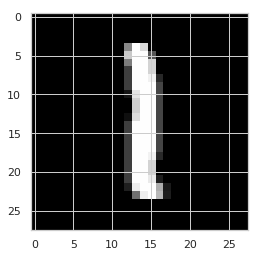

In [62]:
plt.imshow(x[0].view(28,28).cpu().numpy(), cmap='Greys_r')

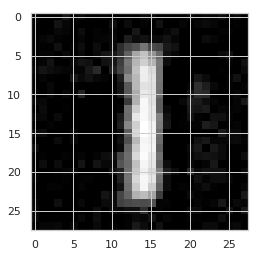

In [63]:
plt.imshow(y[0].view(28,28).cpu().numpy(), cmap='Greys_r')

with the (uninterpretable) 32-dimensional code as

In [73]:
model.encode(x)[0].detach().cpu().numpy()

array([-1.1605313 , -0.5546409 , -0.87471735,  1.4221733 ,  2.7428632 ,
       -0.61159235,  2.8625336 , -1.0251167 , -0.36708927,  2.8548288 ,
       -0.3403125 , -1.8946642 , -0.3629317 , -0.18718502,  1.2758794 ,
        2.8507795 , -1.7359364 , -0.9901097 , -1.4694207 , -0.30859673,
       -2.9324641 , -1.8207943 , -0.1308701 , -0.42032838, -0.6823563 ,
        0.49586338, -0.88479847,  0.11893494,  2.9274364 ,  2.749872  ,
       -0.76846147, -2.6375222 ], dtype=float32)

We can see that the output still is very clearly a 1, but is not quite the same as what we put in. This should make sense to us as we did essentially did some lossy compression by a factor of 24.5x -- definitely non-negligible! The autoencoder learned what combinations of the input dimensions it could make in 32 dimensions to best squeeze as much information in as possible to be able to reconstruct the input. 

## Part 3: Conclusion

In this post, we took a look at the inner workings of the simplest variety of autoencoder, the undercomplete autoencoder; that is, a neural network that maps its input to itself with an intermediate layer of fewer dimensions. But this is just the beginning! More importantly, we introduced the autoencoder as a framework for representation learning given how we apply constraints. In the future, we'll see how this can be used for things other than dimension reduction.

### Postscript

P.S. In this case, we only allowed its combinations to be linear by construction of our encoder and decoder. As a fun note, this should feel very familiar to the linear algebra types out there: what we have is a special case of autoencoder construction that's equivalent to principal components analysis (PCA). Given our data is mean-centered here, this just means our network is learning to project into the subspace of the eigenspace spanned by the first $32$ eigenvectors (ordered by 'importance'/magnitude of eigenvalue). An brief, handwavey outline of why this is the case: PCA can be thought of as trying finding the subspace we can project into that minimizes reconstruction error of how far our projections are from the original points; this is what a linear autoencoder is also doing.